# Logistic Regression

In this assignment we will use the data created in assignment 1 to build a logistic regression classifier to predict whether a shopper will become a repeat shopper.  
 
Before beginning the steps below, check the key from assignment 1 to ensure your datasets are correct. Load the labeled training data and the unlabeled test data into a Python or R session. Both datasets must include the three new columns created in assignment 1. The unlabeled test data will now be referred to as the “score” dataset. 
 
To begin the labeled training data should have 160057 rows and 14 columns. The score data should have ​151484 rows and 13 columns.  
 The following steps can be completed using any packages you choose.  
 
● Recode the target variable, repeater, such that t=1 and f=0. 
● Set any level of the variable category that is in the labeled train set but not in the score set to ‘unknown’ in both sets. Set any level of the variable category that is in the score set but not in the labeled train set to ‘unknown’  in both sets.  
● Set any level of the variable brand that is in the labeled train set but not in the score set to ‘unknown’ in both sets. Set any level of the variable brand that is in the score set but not in the labeled train set to ‘unknown’ in both sets.  
● Set any level of the variable company that is in the labeled train set but not in the score set to ‘unknown’ in both sets. Set any level of the variable company that is in the score set but not in the labeled train set to ‘unknown’  in both sets.  
● Set any level of the variable offer that is in the labeled train set but not in the score set to ‘unknown’ in both sets. Set any level of the variable offer that is in the score set but not in the labeled train set to ‘unknown’ in both sets.  
 
(We ignore the variables category and market for now as their cardinality is too high to be used in an interpretable manner in a logistic regression model without further data preparation steps, e.g. binning based on domain knowledge.) 
 
Now load the two datasets into h2o.  
 
● Use the h2o month() function to create a new categorical variable from the offerdate variable. Create this input variable in the labeled train and score sets.  
● Use the h2o week() function to create a new categorical variable from the offerdate variable. Create this input variable in the labeled train and score sets.  
● Use the h2o dayOfWeek() function to create a new categorical variable from the offerdate variable. Create this input variable in the labeled train and score sets.  
● Use the h2o day() function to create a new numeric variable from the offerdate variable. Create this input variable in the labeled train and score sets.  
● Split the labeled training data into labeled training, validation, and test sets using the h2o split_frame() function. Create a 40%-30%-30% split using the seed 12345.  
DNSC 6279 Spring 2019 Assignment 2 
 
 
We will now train a penalized logistic regression model using several categorical and numeric predictors.  
 
The categorical inputs should be: offer, category, company, brand, whether the exact item was bought in the past, month, week, and day of week. 
 
The numeric inputs should be: offervalue, the average dollar amount purchased in-category, the average quantity purchased in-category, and day of month. 
 
The target is repeater. 
 
Use iteratively reweighted least squares as your solver, use 3 CV folds in your training partition, standardize your inputs, conduct a search for the best lambda parameter, and use a seed of 12345. 
 
Download the POJO for the logistic regression classifier after training. 

Answer the following questions:  
 
1. (2 pts.) By default h2o finds the cutoff that maximizes the F1 statistic in the validation data. What is the cutoff that maximizes the F1 statistic in the validation data? What is the validation data AUC? 
2. (1 pt.) What is the accuracy in the validation data at this cutoff? 
3. (1 pt.) What is the cumulative lift for the model at the 10th decile in the validation data? 
4. (1 pt.) What offer day of the week is most positively associated with becoming a repeat shopper?  
5. (2 pts.) What is the interpretation of the coefficient associated with a customer having bought the exact item in the past? 6. (1 pt.) What is the probability for ID 13584134 in the score set to become a repeat shopper according to your model. 

## Part I   Prepare

In [1]:
# import packages for completing steps
import pandas as pd
import numpy as np

### Import dataset

In [3]:
labeled = pd.read_csv('train_df.csv')
labeled.head(5)

,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,101132595,15,9,t,2013-03-26,1197502,3203,1,106414464,0.75,13474,0.0,0.0000,0
1,101155708,3,2,f,2013-04-06,1197502,3203,1,106414464,0.75,13474,0.0,0.0000,0
2,1029137910,46,15,t,2013-03-21,1199258,4401,1,105100050,2.00,13791,1.0,2.5175,1
3,104818185,4,1,f,2013-04-01,1197502,3203,1,106414464,0.75,13474,0.0,0.0000,0
4,105154900,15,9,t,2013-03-31,1200581,1726,1,104460040,1.25,7668,1.0,3.5900,0


In [6]:
score = pd.read_csv('test.csv')
score.head(5)

,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1026984567,46,1221658,15,2013-06-22,7205,2,103700030,3.0,4294,0.0000,0.0,0.0
1,1,103580546,95,1221658,39,2013-06-29,7205,2,103700030,3.0,4294,2.9375,1.5,30.0
2,2,1047953754,46,1221663,15,2013-06-21,7205,1,103700030,1.5,4294,0.0000,0.0,0.0
3,3,1095959789,46,1230218,15,2013-07-26,706,1,104127141,1.0,26189,0.0000,0.0,0.0
4,4,115842948,88,1221665,14,2013-06-24,7205,1,103700030,1.5,4294,0.0000,0.0,0.0


In [7]:
labeled.loc[labeled['exact_item_bought'] > 0, 'exact_item_bought'] = 1 

labeled.loc[labeled['exact_item_bought'] < 0, 'exact_item_bought'] = 0 

score.loc[score['exact_item_bought'] > 0, 'exact_item_bought'] = 1

score.loc[score['exact_item_bought'] < 0, 'exact_item_bought'] = 0

In order to set any level of the variable category, brand, company and offer those are in the labeled train set but not in the socre set to 'unknown' in both sets, we found the values which are in set labeled but not in score, and used '.replace()' to replace these values as 'unknown' at the labeled dataset. As for the score set, it is the similar operation.


### Category

In [8]:
a=labeled['category'].values.tolist()
b=score['category'].values.tolist()

In [9]:
a_not_b = list(set(a).difference(set(b)))
a_not_b

[3203, 1703, 4401, 3509, 9909]

In [10]:
b_not_a = list(set(b).difference(set(a)))
b_not_a

[5824, 706, 5122, 7205, 4517, 9115, 799]

#### Another try of replace values (it runs much slowly)
#### labeled
for i in labeled['category']:
    if i in a_not_b:
        labeled['category'].replace(i, value="unknown", inplace=True)
labeled
#### score
for i in score['category']:
    if i not in intersection:
        score['category'].replace(i, value="unknown", inplace=True)
score

In [11]:
labeled['category'].replace(to_replace = a_not_b, value='unknown',inplace = True)
labeled

,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,101132595,15,9,t,2013-03-26,1197502,unknown,1,106414464,0.75,13474,0.000000,0.000000,0
1,101155708,3,2,f,2013-04-06,1197502,unknown,1,106414464,0.75,13474,0.000000,0.000000,0
2,1029137910,46,15,t,2013-03-21,1199258,unknown,1,105100050,2.00,13791,1.000000,2.517500,1
3,104818185,4,1,f,2013-04-01,1197502,unknown,1,106414464,0.75,13474,0.000000,0.000000,0
4,105154900,15,9,t,2013-03-31,1200581,1726,1,104460040,1.25,7668,1.000000,3.590000,0
5,1070364166,214,8,f,2013-03-25,1198272,5558,1,107120272,1.50,5072,0.000000,0.000000,0
6,1074590780,214,8,f,2013-04-17,1197502,unknown,1,106414464,0.75,13474,0.000000,0.000000,0
7,108007968,15,9,f,2013-04-01,1197502,unknown,1,106414464,0.75,13474,0.000000,0.000000,0
8,1100825830,46,15,f,2013-04-24,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0
9,1118842110,214,8,f,2013-04-28,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0


In [12]:
score['category'].replace(to_replace = b_not_a, value='unknown',inplace = True)
score

,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1026984567,46,1221658,15,2013-06-22,unknown,2,103700030,3.0,4294,0.000000,0.000000,0.0
1,1,103580546,95,1221658,39,2013-06-29,unknown,2,103700030,3.0,4294,2.937500,1.500000,1.0
2,2,1047953754,46,1221663,15,2013-06-21,unknown,1,103700030,1.5,4294,0.000000,0.000000,0.0
3,3,1095959789,46,1230218,15,2013-07-26,unknown,1,104127141,1.0,26189,0.000000,0.000000,0.0
4,4,115842948,88,1221665,14,2013-06-24,unknown,1,103700030,1.5,4294,0.000000,0.000000,0.0
5,5,116021835,95,1213242,39,2013-05-21,unknown,1,105190050,2.0,26456,6.426667,1.333333,1.0
6,6,116517444,15,1219903,9,2013-06-29,unknown,1,1076211171,1.5,17286,0.000000,0.000000,0.0
7,7,119994909,15,1203439,9,2013-05-11,unknown,1,107106878,1.5,17311,14.490000,1.000000,1.0
8,8,120855534,95,1230218,39,2013-07-25,unknown,1,104127141,1.0,26189,3.923333,1.000000,1.0
9,9,120941072,4,1219903,1,2013-06-29,unknown,1,1076211171,1.5,17286,0.000000,0.000000,0.0


### Brand

In [13]:
c=labeled['brand'].values.tolist()
d=score['brand'].values.tolist()

In [14]:
c_not_d = list(set(c).difference(set(d)))
c_not_d

[13474, 28840, 875, 6732, 13791]

In [15]:
d_not_c = list(set(d).difference(set(c)))
d_not_c

[4294, 17286, 1322, 26189, 93904, 26456, 17311]

In [16]:
labeled['brand'].replace(to_replace = c_not_d, value='unknown',inplace = True)
labeled

,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,101132595,15,9,t,2013-03-26,1197502,unknown,1,106414464,0.75,unknown,0.000000,0.000000,0
1,101155708,3,2,f,2013-04-06,1197502,unknown,1,106414464,0.75,unknown,0.000000,0.000000,0
2,1029137910,46,15,t,2013-03-21,1199258,unknown,1,105100050,2.00,unknown,1.000000,2.517500,1
3,104818185,4,1,f,2013-04-01,1197502,unknown,1,106414464,0.75,unknown,0.000000,0.000000,0
4,105154900,15,9,t,2013-03-31,1200581,1726,1,104460040,1.25,7668,1.000000,3.590000,0
5,1070364166,214,8,f,2013-03-25,1198272,5558,1,107120272,1.50,5072,0.000000,0.000000,0
6,1074590780,214,8,f,2013-04-17,1197502,unknown,1,106414464,0.75,unknown,0.000000,0.000000,0
7,108007968,15,9,f,2013-04-01,1197502,unknown,1,106414464,0.75,unknown,0.000000,0.000000,0
8,1100825830,46,15,f,2013-04-24,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0
9,1118842110,214,8,f,2013-04-28,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0


In [17]:
score['brand'].replace(to_replace = d_not_c, value='unknown',inplace = True)
score

,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1026984567,46,1221658,15,2013-06-22,unknown,2,103700030,3.0,unknown,0.000000,0.000000,0.0
1,1,103580546,95,1221658,39,2013-06-29,unknown,2,103700030,3.0,unknown,2.937500,1.500000,1.0
2,2,1047953754,46,1221663,15,2013-06-21,unknown,1,103700030,1.5,unknown,0.000000,0.000000,0.0
3,3,1095959789,46,1230218,15,2013-07-26,unknown,1,104127141,1.0,unknown,0.000000,0.000000,0.0
4,4,115842948,88,1221665,14,2013-06-24,unknown,1,103700030,1.5,unknown,0.000000,0.000000,0.0
5,5,116021835,95,1213242,39,2013-05-21,unknown,1,105190050,2.0,unknown,6.426667,1.333333,1.0
6,6,116517444,15,1219903,9,2013-06-29,unknown,1,1076211171,1.5,unknown,0.000000,0.000000,0.0
7,7,119994909,15,1203439,9,2013-05-11,unknown,1,107106878,1.5,unknown,14.490000,1.000000,1.0
8,8,120855534,95,1230218,39,2013-07-25,unknown,1,104127141,1.0,unknown,3.923333,1.000000,1.0
9,9,120941072,4,1219903,1,2013-06-29,unknown,1,1076211171,1.5,unknown,0.000000,0.000000,0.0


### Company

In [18]:
e=labeled['company'].values.tolist()
f=score['company'].values.tolist()

In [19]:
e_not_f = list(set(e).difference(set(f)))
e_not_f

[106414464, 107127979, 105100050, 103320030, 1089520383]

In [20]:
f_not_e = list(set(f).difference(set(e)))
f_not_e

[105190050, 1076211171, 105450050, 104127141, 107106878, 108500080, 103700030]

In [21]:
labeled['company'].replace(to_replace = e_not_f, value='unknown',inplace = True)
labeled

,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,101132595,15,9,t,2013-03-26,1197502,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
1,101155708,3,2,f,2013-04-06,1197502,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
2,1029137910,46,15,t,2013-03-21,1199258,unknown,1,unknown,2.00,unknown,1.000000,2.517500,1
3,104818185,4,1,f,2013-04-01,1197502,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
4,105154900,15,9,t,2013-03-31,1200581,1726,1,104460040,1.25,7668,1.000000,3.590000,0
5,1070364166,214,8,f,2013-03-25,1198272,5558,1,107120272,1.50,5072,0.000000,0.000000,0
6,1074590780,214,8,f,2013-04-17,1197502,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
7,108007968,15,9,f,2013-04-01,1197502,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
8,1100825830,46,15,f,2013-04-24,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0
9,1118842110,214,8,f,2013-04-28,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0


In [22]:
score['company'].replace(to_replace = f_not_e, value='unknown',inplace = True)
score

,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1026984567,46,1221658,15,2013-06-22,unknown,2,unknown,3.0,unknown,0.000000,0.000000,0.0
1,1,103580546,95,1221658,39,2013-06-29,unknown,2,unknown,3.0,unknown,2.937500,1.500000,1.0
2,2,1047953754,46,1221663,15,2013-06-21,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
3,3,1095959789,46,1230218,15,2013-07-26,unknown,1,unknown,1.0,unknown,0.000000,0.000000,0.0
4,4,115842948,88,1221665,14,2013-06-24,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
5,5,116021835,95,1213242,39,2013-05-21,unknown,1,unknown,2.0,unknown,6.426667,1.333333,1.0
6,6,116517444,15,1219903,9,2013-06-29,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
7,7,119994909,15,1203439,9,2013-05-11,unknown,1,unknown,1.5,unknown,14.490000,1.000000,1.0
8,8,120855534,95,1230218,39,2013-07-25,unknown,1,unknown,1.0,unknown,3.923333,1.000000,1.0
9,9,120941072,4,1219903,1,2013-06-29,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0


### Offer

In [23]:
g=labeled['offer'].values.tolist()
h=score['offer'].values.tolist()

In [24]:
g_not_h = list(set(g).difference(set(h)))
g_not_h

[1200578, 1200579, 1200988, 1203052, 1199256, 1199258, 1194044, 1197502]

In [25]:
h_not_g = list(set(h).difference(set(g)))
h_not_g

[1221665,
 1190530,
 1221666,
 1221667,
 1219903,
 1230218,
 1203439,
 1220502,
 1220503,
 1219900,
 1221658,
 1213242,
 1221663]

In [26]:
labeled['offer'].replace(to_replace = g_not_h, value='unknown',inplace = True)
labeled

,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,101132595,15,9,t,2013-03-26,unknown,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
1,101155708,3,2,f,2013-04-06,unknown,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
2,1029137910,46,15,t,2013-03-21,unknown,unknown,1,unknown,2.00,unknown,1.000000,2.517500,1
3,104818185,4,1,f,2013-04-01,unknown,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
4,105154900,15,9,t,2013-03-31,1200581,1726,1,104460040,1.25,7668,1.000000,3.590000,0
5,1070364166,214,8,f,2013-03-25,1198272,5558,1,107120272,1.50,5072,0.000000,0.000000,0
6,1074590780,214,8,f,2013-04-17,unknown,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
7,108007968,15,9,f,2013-04-01,unknown,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0
8,1100825830,46,15,f,2013-04-24,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0
9,1118842110,214,8,f,2013-04-28,1208251,2202,1,104460040,2.00,3718,0.000000,0.000000,0


In [27]:
score['offer'].replace(to_replace = h_not_g, value='unknown',inplace = True)
score

,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1026984567,46,unknown,15,2013-06-22,unknown,2,unknown,3.0,unknown,0.000000,0.000000,0.0
1,1,103580546,95,unknown,39,2013-06-29,unknown,2,unknown,3.0,unknown,2.937500,1.500000,1.0
2,2,1047953754,46,unknown,15,2013-06-21,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
3,3,1095959789,46,unknown,15,2013-07-26,unknown,1,unknown,1.0,unknown,0.000000,0.000000,0.0
4,4,115842948,88,unknown,14,2013-06-24,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
5,5,116021835,95,unknown,39,2013-05-21,unknown,1,unknown,2.0,unknown,6.426667,1.333333,1.0
6,6,116517444,15,unknown,9,2013-06-29,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0
7,7,119994909,15,unknown,9,2013-05-11,unknown,1,unknown,1.5,unknown,14.490000,1.000000,1.0
8,8,120855534,95,unknown,39,2013-07-25,unknown,1,unknown,1.0,unknown,3.923333,1.000000,1.0
9,9,120941072,4,unknown,1,2013-06-29,unknown,1,unknown,1.5,unknown,0.000000,0.000000,0.0


#### Download the dataset as .csv form

In [28]:
labeled.to_csv('Labeled1.csv', header = True)

In [29]:
score.to_csv('Score2.csv', header = True)

## Part II h2o

In [30]:
#import h2o
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [31]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\YIDANW~1\AppData\Local\Temp\tmp9h6f7qto
  JVM stdout: C:\Users\YIDANW~1\AppData\Local\Temp\tmp9h6f7qto\h2o_Yidan_Wang_started_from_python.out
  JVM stderr: C:\Users\YIDANW~1\AppData\Local\Temp\tmp9h6f7qto\h2o_Yidan_Wang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_Yidan_Wang_h6g5vg
H2O cluster total nodes:,1
H2O cluster free memory:,3.524 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [32]:
# import dataset in h2o
labelh2o = h2o.import_file("Labeled1.csv")
labelh2o.describe

Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought
0,1.01133e+08,15,9,t,2013-03-26 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0
1,1.01156e+08,3,2,f,2013-04-06 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0
2,1.02914e+09,46,15,t,2013-03-21 00:00:00,unknown,unknown,1,unknown,2,unknown,1,2.5175,1
3,1.04818e+08,4,1,f,2013-04-01 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0
4,1.05155e+08,15,9,t,2013-03-31 00:00:00,1200581,1726,1,104460040,1.25,7668,1,3.59,0
5,1.07036e+09,214,8,f,2013-03-25 00:00:00,1198272,5558,1,107120272,1.5,5072,0,0,0
6,1.07459e+09,214,8,f,2013-04-17 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0
7,1.08008e+08,15,9,f,2013-04-01 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0
8,1.10083e+09,46,15,f,2013-04-24 00:00:00,1208251,2202,1,104460040,2,3718,0,0,0
9,1.11884e+09,214,8,f,2013-04-28 00:00:00,1208251,2202,1,104460040,2,3718,0,0,0


<bound method H2OFrame.describe of >

In [33]:
scoreh2o = h2o.import_file('Score2.csv')
scoreh2o.describe

Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought
0,0,1.02698e+09,46,unknown,15,2013-06-22 00:00:00,unknown,2,unknown,3,unknown,0,0,0
1,1,1.03581e+08,95,unknown,39,2013-06-29 00:00:00,unknown,2,unknown,3,unknown,2.9375,1.5,1
2,2,1.04795e+09,46,unknown,15,2013-06-21 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0
3,3,1.09596e+09,46,unknown,15,2013-07-26 00:00:00,unknown,1,unknown,1,unknown,0,0,0
4,4,1.15843e+08,88,unknown,14,2013-06-24 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0
5,5,1.16022e+08,95,unknown,39,2013-05-21 00:00:00,unknown,1,unknown,2,unknown,6.42667,1.33333,1
6,6,1.16517e+08,15,unknown,9,2013-06-29 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0
7,7,1.19995e+08,15,unknown,9,2013-05-11 00:00:00,unknown,1,unknown,1.5,unknown,14.49,1,1
8,8,1.20856e+08,95,unknown,39,2013-07-25 00:00:00,unknown,1,unknown,1,unknown,3.92333,1,1
9,9,1.20941e+08,4,unknown,1,2013-06-29 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0


<bound method H2OFrame.describe of >

#### split the offerdate vairable to month, week, day of week, day; and set month, week, and day of week as catregorical variables

In [34]:
labelh2o['month']=labelh2o['offerdate'].month().asfactor()

In [35]:
labelh2o['week']=labelh2o['offerdate'].week().asfactor()

In [36]:
labelh2o['dayOfWeek']=labelh2o['offerdate'].dayOfWeek().asfactor()

In [37]:
labelh2o['day']=labelh2o['offerdate'].day()

In [38]:
labelh2o

C1,id,chain,market,repeater,offerdate,offer,category,quantity,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought,month,week,dayOfWeek,day
0,1.01133e+08,15,9,t,2013-03-26 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0,3,13,Tue,26
1,1.01156e+08,3,2,f,2013-04-06 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0,4,14,Sat,6
2,1.02914e+09,46,15,t,2013-03-21 00:00:00,unknown,unknown,1,unknown,2,unknown,1,2.5175,1,3,12,Thu,21
3,1.04818e+08,4,1,f,2013-04-01 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0,4,14,Mon,1
4,1.05155e+08,15,9,t,2013-03-31 00:00:00,1200581,1726,1,104460040,1.25,7668,1,3.59,0,3,13,Sun,31
5,1.07036e+09,214,8,f,2013-03-25 00:00:00,1198272,5558,1,107120272,1.5,5072,0,0,0,3,13,Mon,25
6,1.07459e+09,214,8,f,2013-04-17 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0,4,16,Wed,17
7,1.08008e+08,15,9,f,2013-04-01 00:00:00,unknown,unknown,1,unknown,0.75,unknown,0,0,0,4,14,Mon,1
8,1.10083e+09,46,15,f,2013-04-24 00:00:00,1208251,2202,1,104460040,2,3718,0,0,0,4,17,Wed,24
9,1.11884e+09,214,8,f,2013-04-28 00:00:00,1208251,2202,1,104460040,2,3718,0,0,0,4,17,Sun,28


#### Set offer, category, company, brand, whether the exact item was bought in the past as categorical variables

In [39]:
labelh2o['offer']=labelh2o['offer'].asfactor()
labelh2o['category']=labelh2o['category'].asfactor()
labelh2o['company']=labelh2o['company'].asfactor()
labelh2o['brand']=labelh2o['brand'].asfactor()
labelh2o['exact_item_bought']=labelh2o['exact_item_bought'].asfactor()

In [40]:
scoreh2o['month']=scoreh2o['offerdate'].month().asfactor()
scoreh2o['week']=scoreh2o['offerdate'].week().asfactor()
scoreh2o['dayOfWeek']=scoreh2o['offerdate'].dayOfWeek().asfactor()
scoreh2o['day']=scoreh2o['offerdate'].day()

In [41]:
scoreh2o['offer']=scoreh2o['offer'].asfactor()
scoreh2o['category']=scoreh2o['category'].asfactor()
scoreh2o['company']=scoreh2o['company'].asfactor()
scoreh2o['brand']=scoreh2o['brand'].asfactor()
scoreh2o['exact_item_bought']=scoreh2o['exact_item_bought'].asfactor()

In [42]:
scoreh2o

C1,Unnamed: 0,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,avg_purchaseamount,avg_purchasequantity,exact_item_bought,month,week,dayOfWeek,day
0,0,1.02698e+09,46,unknown,15,2013-06-22 00:00:00,unknown,2,unknown,3,unknown,0,0,0,6,25,Sat,22
1,1,1.03581e+08,95,unknown,39,2013-06-29 00:00:00,unknown,2,unknown,3,unknown,2.9375,1.5,1,6,26,Sat,29
2,2,1.04795e+09,46,unknown,15,2013-06-21 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0,6,25,Fri,21
3,3,1.09596e+09,46,unknown,15,2013-07-26 00:00:00,unknown,1,unknown,1,unknown,0,0,0,7,30,Fri,26
4,4,1.15843e+08,88,unknown,14,2013-06-24 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0,6,26,Mon,24
5,5,1.16022e+08,95,unknown,39,2013-05-21 00:00:00,unknown,1,unknown,2,unknown,6.42667,1.33333,1,5,21,Tue,21
6,6,1.16517e+08,15,unknown,9,2013-06-29 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0,6,26,Sat,29
7,7,1.19995e+08,15,unknown,9,2013-05-11 00:00:00,unknown,1,unknown,1.5,unknown,14.49,1,1,5,19,Sat,11
8,8,1.20856e+08,95,unknown,39,2013-07-25 00:00:00,unknown,1,unknown,1,unknown,3.92333,1,1,7,30,Thu,25
9,9,1.20941e+08,4,unknown,1,2013-06-29 00:00:00,unknown,1,unknown,1.5,unknown,0,0,0,6,26,Sat,29


#### Split the labeled training data into labeled training, validation, and test sets

In [43]:
train, test, valid = labelh2o.split_frame(ratios=[0.4,0.3], seed = 12345)

#### The target is repeater

In [44]:
y = 'repeater'
x = [name for name in labelh2o.columns if name not in ['C1','id', 'chain', 'market', 'quantity','offerdate',y]]

In [45]:
print(y)
print(x)

repeater
['offer', 'category', 'company', 'offervalue', 'brand', 'avg_purchasequantity', 'avg_purchaseamount', 'exact_item_bought', 'month', 'week', 'dayOfWeek', 'day']


In [46]:
train[y] = train [y].asfactor()
test[y] = test[y].asfactor()

#### The logistic regression 

In [47]:
# initialize
label_glm = H2OGeneralizedLinearEstimator(family='binomial',
                                         model_id='label_glm2',
                                         solver='IRLSM',
                                          nfolds = 3,
                                         standardize=True,
                                         lambda_search=True,
                                         seed = 12345)
# IRLSM = iteratively reweighted least squares 
# train
label_glm.train(x,y,training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [48]:
# measure train and test AUC
print(label_glm.auc(train=True))
print(label_glm.model_performance(test_data=test).auc())


0.6694773621382184
0.6763527157761703


#### Download the POJO for the logistic regression classifier afer training

In [49]:
h2o.download_pojo(label_glm)

/*
  Licensed under the Apache License, Version 2.0
    http://www.apache.org/licenses/LICENSE-2.0.html

  AUTOGENERATED BY H2O at 2019-03-22T00:04:42.070-04:00
  3.22.1.5
  
  Standalone prediction code with sample test data for GLMModel named label_glm2

  How to download, compile and execute:
      mkdir tmpdir
      cd tmpdir
      curl http://127.0.0.1:54321/3/h2o-genmodel.jar > h2o-genmodel.jar
      curl http://127.0.0.1:54321/3/Models.java/label_glm2 > label_glm2.java
      javac -cp h2o-genmodel.jar -J-Xmx2g -J-XX:MaxPermSize=128m label_glm2.java

     (Note:  Try java argument -XX:+PrintCompilation to show runtime JIT compiler behavior.)
*/
import java.util.Map;
import hex.genmodel.GenModel;
import hex.genmodel.annotations.ModelPojo;

@ModelPojo(name="label_glm2", algorithm="glm")
public class label_glm2 extends GenModel {
  public hex.ModelCategory getModelCategory() { return hex.ModelCategory.Binomial; }

  public boolean isSupervised() { return true; }
  public int nfeatur

# Part III Answering questions

### Question 1

In [50]:
# F1 score in the validation data
label_glm.F1(valid=True)

[[0.2342309099218798, 0.48210766517996057]]

In [51]:
# the cutoff that maximizes the F1 statistic in the validation data
cutoff = label_glm.model_performance(test_data=valid).find_threshold_by_max_metric('f1')
cutoff

0.2342309099218798

In [52]:
# the validation data AUC
print(label_glm.auc(valid=True))

0.6759484264552232


The cutoff that maximizeds the F1 statistic in the validation data is 0.2342309099218798 and he validation data AUC is 0.6759484264552232

### Question 2

In [53]:
# the accuracy in the validation data at this cutoff
label_glm.model_performance(test_data=valid).accuracy([cutoff])

[[0.2342309099218798, 0.5835262225002606]]

The accuracy in the validation data at this cutoff is [[0.2342309099218798, 0.5835262225002606]]

### Question 3

In [54]:
#the cumulative lift for the model at the 10th decile
gainslift = label_glm.gains_lift(valid = True) 
lift = gainslift.as_data_frame() 
lift_deciles = lift.iloc[pd.np.r_[10],:]
lift_deciles

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
10,,11,0.500031,0.255947,1.061751,1.365274,0.288514,0.292051,0.370991,0.368093,0.106208,0.68268,6.175062,36.527412


The cumulative_lift is 1.365274


### Question 4

In [55]:
# print non-zero model parameters
for name, val in label_glm.coef().items():
    if val != 0.0:
        print(name, ': ', val)

Intercept :  1.0777946346188738
offer.1198272 :  0.15641594062769915
offer.1200581 :  -0.1993894019245035
offer.1204576 :  -0.21074091480093626
offer.1204821 :  -0.08258896412779768
offer.1208252 :  0.8012754693042345
offer.1208501 :  0.39955750050948513
offer.unknown :  -0.19703670256008954
week.9 :  0.5148016280071068
week.10 :  0.4686971848980452
week.11 :  -0.4180272972788584
week.12 :  -0.06465592690378563
week.13 :  -0.1782119743144179
week.14 :  -0.17237530605724655
week.16 :  -0.19665552296175348
week.17 :  0.011231080591000177
week.18 :  0.13384708427475736
category.1726 :  -0.13831520734158098
category.2202 :  0.6049224427960399
category.5616 :  -0.21074091480093904
category.5619 :  -0.1019059942596613
category.6202 :  0.14195970342990474
category.unknown :  -0.19703670256008526
brand.102504 :  -0.10190599425966095
brand.15889 :  -0.21074091480093943
brand.3718 :  0.6049224427960459
brand.64486 :  0.14195970342990466
brand.7668 :  -0.8391936395133585
company.104610040 :  -0.2

Saturday is most positively associated with becoming a repeat shopper 

### Question 5

In [56]:
label_glm.coef()

{'Intercept': 1.0777946346188738,
 'offer.1198271': 0.0,
 'offer.1198272': 0.15641594062769915,
 'offer.1198273': 0.0,
 'offer.1198274': 0.0,
 'offer.1198275': 0.0,
 'offer.1200581': -0.1993894019245035,
 'offer.1200582': 0.0,
 'offer.1200584': 0.0,
 'offer.1204576': -0.21074091480093626,
 'offer.1204821': -0.08258896412779768,
 'offer.1204822': 0.0,
 'offer.1208251': 0.0,
 'offer.1208252': 0.8012754693042345,
 'offer.1208329': 0.0,
 'offer.1208501': 0.39955750050948513,
 'offer.1208503': 0.0,
 'offer.unknown': -0.19703670256008954,
 'week.9': 0.5148016280071068,
 'week.10': 0.4686971848980452,
 'week.11': -0.4180272972788584,
 'week.12': -0.06465592690378563,
 'week.13': -0.1782119743144179,
 'week.14': -0.17237530605724655,
 'week.15': 0.0,
 'week.16': -0.19665552296175348,
 'week.17': 0.011231080591000177,
 'week.18': 0.13384708427475736,
 'category.1726': -0.13831520734158098,
 'category.2119': 0.0,
 'category.2202': 0.6049224427960399,
 'category.3504': 0.0,
 'category.5558': 0.0,

Holding all other variables constant, one increase in the 'exact_item_bought.1' is associated with the log odds of repeater by exp(0.24386402281701114).
Holding all other variables constant, one increase in the 'exact_item_bought.0' is associated with the log odds of repeater by exp(-0.528278251167)

### Question 6

In [57]:
proid = scoreh2o['id'] == 13584134
value = scoreh2o[proid,:]
value = value[:,x]
value

offer,category,company,offervalue,brand,avg_purchasequantity,avg_purchaseamount,exact_item_bought,month,week,dayOfWeek,day
unknown,unknown,unknown,1.5,unknown,1,2.84,1,6,26,Thu,27


In [58]:
predictvalue = label_glm.predict(value)

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'week' has levels not trained on: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  warnings.warn(w)
C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'month' has levels not trained on: [5, 6, 7]
  warnings.warn(w)


In [59]:
predict = label_glm.predict(value)
predict.describe()
predict['p1']

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'week' has levels not trained on: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  warnings.warn(w)
C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'month' has levels not trained on: [5, 6, 7]
  warnings.warn(w)


Rows:1
Cols:3




,predict,f,t
type,enum,real,real
mins,,0.772032404253285,0.227967595746715
mean,,0.772032404253285,0.227967595746715
maxs,,0.772032404253285,0.227967595746715
sigma,,0.0,0.0
zeros,,0,0
missing,0,0,0
0,f,0.772032404253285,0.227967595746715


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column p1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_29_sid_b947 (cols_py predictions_9235_label_glm2_on_py_28_sid_b947 'p1'))", 'session_id': '_sid_b947'}


Probability is 0.227968

In [60]:
h2o.cluster()

SyntaxError: invalid syntax (<ipython-input-60-9c80207f79ee>, line 1)

### bonus

There might be correlation among attributes.

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

We can see that many variables are correlated

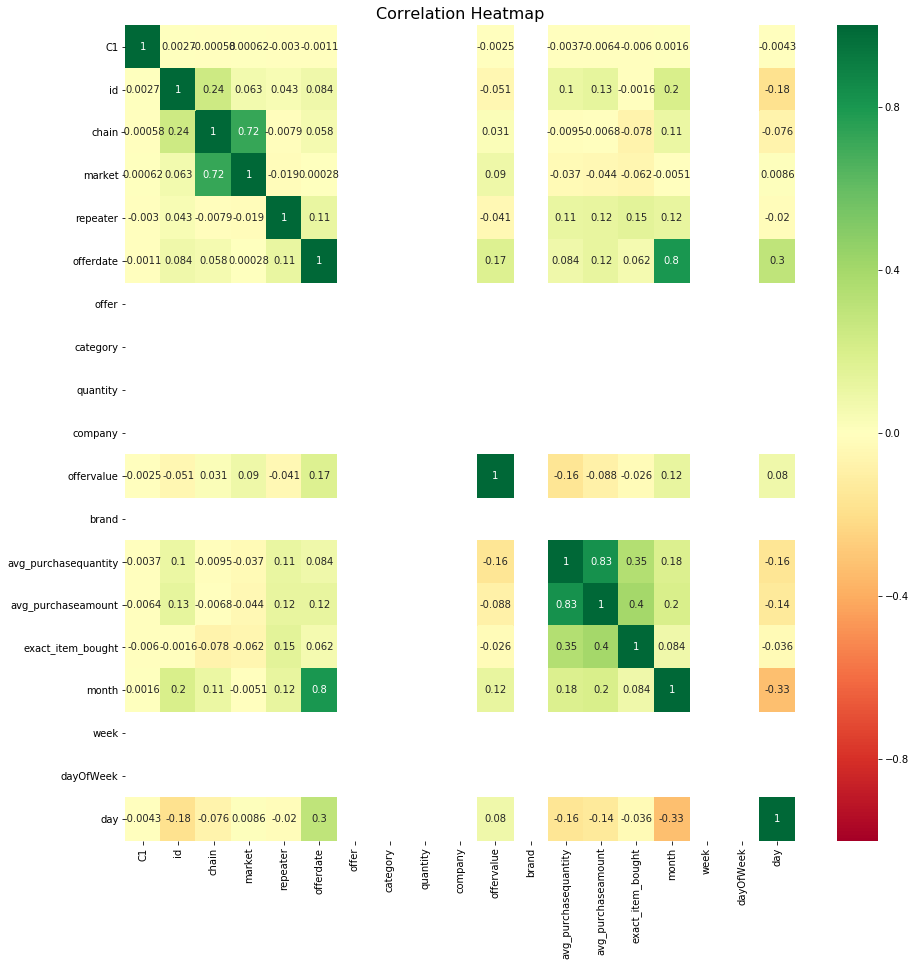

In [63]:
plt.figure(figsize=(15,15))
corr = train.cor().as_data_frame()
corr.index = train.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()